# Computing inter-annotator agreement for span annotation tasks

In [29]:
from IPython.display import display, HTML
notebook_name = "annotation/compute_ica_pledge_extraction"
display(HTML("""
<br>
<a target="_blank" href="https://colab.research.google.com/github/haukelicht/advanced_text_analysis/blob/main/notebooks/%s.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
""" % notebook_name
))

## Background

### Span annotations

**Span annotation** is a _sequence labeling_ task (cf. Jurafsky & Martin [2025](https://web.stanford.edu/~jurafsky/slp3/17.pdf)) that involves marking passages in a text that represent a certain concept, such as an entity.

Accordingly, span annotations recorded **character spans** that indicate which passage(s) of a text were marked (if any). 
At least this is the most granular way of representing sequence labeling annotations.
(But see the [CoNLL format](https://www.geeksforgeeks.org/nlp/what-is-conll-data-format/), that records annotations at the token level.)

The example below illustrates this for an English sentence.
The marked span is represented by a list with two elements that indicate the span's character start and end positions in the text:


In [1]:
translation = "We will restrict foreign equity holding in private television broadcasting to 20%."
span = [8, 39]

print("first character of the span:", repr(translation[span[0]]))
print("last character of the span:", repr(translation[span[1]-1]))
print("extracted span:", repr(translation[span[0]:span[1]]))

first character of the span: 'r'
last character of the span: 'g'
extracted span: 'restrict foreign equity holding'


### Computing inter-annotator agreement for sequence labeling tasks.

We want to compute to what extent annotators marked spans agree with each other.
Specifically, following Krippendorff and others, we want to compute a _chance-adjusted_ inter-annotator agreement metric that adjusts for the probability that an agreement arises by chance.

The appraoch to computing inter-coder agreement adopted in this notebook is based on Baylan et al. ([2022](https://doi.org/10.1145/3485447.3512242)).

### Setup

In [ ]:
# check if on colab
COLAB = True
try:
    import google.colab
except:
    COLAB=False

if COLAB:
    # shallow clone of current state of main branch 
    !git clone --branch main --single-branch --depth 1 --filter=blob:none https://github.com/haukelicht/advanced_text_analysis.git
    # go into repo directory
    !cd advanced_text_analysis
    # make repo root findable for python
    !export PYTHONPATH="$(pwd):${PYTHONPATH}"

    # install required packages
    !pip install pandas~=2.2.2 scipy~=1.10.1 nltk==3.9.1 krippendorff==0.8.1

    # get NLTK tokenizer data
    from nltk import download
    download('punkt')

In [ ]:
from pathlib import Path

import pandas as pd
import numpy as np

from nltk.tokenize import TreebankWordTokenizer

# !pip install krippendorff==0.8.1
from krippendorff import alpha as k_alpha

# NOTE: you may need to adjust your PYTHONPATH so that the src module can be found
from src.annotation.agreement import InterAnnotatorAgreement, overlap_distance, split_iaa_by_item

data_path = "data/labeled/fornaciari_we_2021"
if not COLAB:
    data_path = "../.." + data_path
data_path = Path(data_path)

## Read the annotations

In [3]:
# TODO: change `"llms"` to the name of your group's folder
annotations_path = data_path / "annotations" / "extraction" / "llms"

# list all annotation files produced by doccano 
#  (each records annotations by one annotator)
fps = list(annotations_path.glob('*.jsonl'))

# read the annoations into a long-format DataFrame
annotations = pd.concat({fp.stem: pd.read_json(fp, lines=True) for fp in fps}, ignore_index=False).reset_index(level=0, names=['annotator'])

# list unique annotators
annotations.annotator.unique().tolist()

['DeepSeek-V3-0324',
 'Qwen3-235B-A22B-Instruct-2507',
 'gpt-oss-120b',
 'Llama-4-Maverick-17B-128E-Instruct']

In [4]:
# add metadata and reformat the DataFrame
if 'metadata' in annotations.columns:
    metadata = annotations['metadata'].apply(pd.Series)
    metadata.drop(columns=['label'], inplace=True)
    annotations[metadata.columns] = metadata
    annotations.drop(columns=['metadata'], inplace=True)

annotations = annotations.sort_values(by=['text_id', 'annotator']).reset_index(drop=True)
annotations = annotations[['text_id', 'text', 'annotator', 'label']]
annotations['spans'] = annotations.apply(lambda x: [x['text'][slice(*lab)] for lab in x['label']], axis=1)

# count number of annotations per annotator and text
annotations['n_annos'] = annotations.label.map(len)
annotations['no_annos'] = annotations['n_annos']==0

We are interested to what extent annotators marked spans agree.
Do the words marked in a sentence by one annotator agree with those marked by the other annotators?

But note that annotated words may vary a lot in their character length.
We don't want this varation to influence our agreement measure.

So we need to convert the character-level into token-level annotations.
For this, we first tokenize the sentence and than map the character-level span start and end indexes to their correspondong token-level indexes:

In [ ]:
tokenizer = TreebankWordTokenizer()

# list(tokenizer.span_tokenize(text))
def character_to_token_spans(text: str, spans: list[tuple[int, int]]) -> list[tuple[int, int]]:
    token_spans = list(tokenizer.span_tokenize(text))
    token_span_list = []
    for span in spans:
        start_char, end_char = span
        # Find the first token that starts after or at the start_char
        start_token = next((i for i, (s, _) in enumerate(token_spans) if s >= start_char), None)
        # Find the last token that ends before or at the end_char
        end_token = next((i for i, (_, e) in reversed(list(enumerate(token_spans))) if e <= end_char), None)
        if start_token is not None and end_token is not None and start_token <= end_token:
            token_span_list.append((start_token, end_token + 1))  # +1 to make it exclusive
    return token_span_list

The example below illustrates the functionality of the `character_to_token_spans()` function.

In [6]:
text = r"We will restrict foreign equity holding in private television broadcasting to 20% and prevent cross holding to avoid emergence of monopolies in the media."
# annotation
annotation = [[8, 81], [86, 153]]
print('extracted spans:', end='')
print('', *[text[slice(*span)] for span in annotation], sep='\n - ')
print()

tok_spans = character_to_token_spans(text, annotation)
print("token-level annotations:", tok_spans)
tokens = tokenizer.tokenize(text)
print()

print('tokens in extracted spans:')
for tspan in tok_spans:
    print(' - ', tokens[slice(*tspan)])

extracted spans:
 - restrict foreign equity holding in private television broadcasting to 20%
 - prevent cross holding to avoid emergence of monopolies in the media

token-level annotations: [(2, 13), (14, 25)]

tokens in extracted spans:
 -  ['restrict', 'foreign', 'equity', 'holding', 'in', 'private', 'television', 'broadcasting', 'to', '20', '%']
 -  ['prevent', 'cross', 'holding', 'to', 'avoid', 'emergence', 'of', 'monopolies', 'in', 'the', 'media']


Let's apply this logic to all the data:

In [7]:
# extract tokens
annotations['tokens'] = annotations.apply(lambda x: tokenizer.tokenize(x['text']), axis=1)
# determine token-level span informations
annotations['token_spans'] = annotations.apply(lambda x: character_to_token_spans(x['text'], x['label']), axis=1)

Let's look at an example

In [8]:
ex = annotations.loc[annotations.text_id == 604, ['text', 'annotator', 'spans', 'label', 'tokens', 'token_spans']]
print('Text:', repr(ex.text.iloc[0]))
print('Annotations:')
for _, row in ex.iterrows():
    print(' -', row.annotator+':', end='')
    print('', *row['spans'], sep='\n   - ')
    print()

Text: 'Reservations for the poor among ‘Forward Classes’ will be introduced after receiving recommendations of the Commission set up for this purpose .'
Annotations:
 - DeepSeek-V3-0324:
   - Reservations for the poor among ‘Forward Classes’ will be introduced after receiving recommendations of the Commission set up for this purpose

 - Llama-4-Maverick-17B-128E-Instruct:

 - Qwen3-235B-A22B-Instruct-2507:
   - Reservations for the poor among ‘Forward Classes’ will be introduced after receiving recommendations of the Commission set up for this purpose

 - gpt-oss-120b:
   - Reservations for the poor among ‘Forward Classes’ will be introduced after receiving recommendations of the Commission set up for this purpose



## Compute inter-annotator agreement

### Sentence level

In [9]:
tmp = annotations[['annotator', 'text_id', 'no_annos']].copy()
tmp['no_annos'] = ~tmp['no_annos']
tmp = tmp.pivot(index='annotator', columns='text_id', values='no_annos').fillna(False).astype(int)
k_alpha(tmp.values, level_of_measurement='nominal')
# NOTE: just scratching the threshold of 0.67 for acceptable agreement (see https://www.sciencedirect.com/science/article/pii/S2215016123005411)

0.6922466039707419

Krippendorff (cited in Neuendorff, 2017) names the following standards

- Rely only on variables with reliabilities above α = .800.
- Consider variables with reliabilities between α = .667 and α = .800 only for drawing tentative conclusions.

### Span level

In [10]:
# Braylan et al.'s code requires that annotators and items are identified by integer IDs
annotations['item_id'] = pd.Categorical(annotations['text_id']).codes
annotations['annotator_id'] = pd.Categorical(annotations['annotator']).codes

In [11]:
# create an agreement object with the entity distance function
iaa = InterAnnotatorAgreement(
    annotations, 
    item_colname="item_id", 
    uid_colname="annotator_id", 
    label_colname="label", 
    distance_fn=overlap_distance
)

In [12]:
# compute agreement measures
iaa.setup(parallel_calc=False)
krippendorff_alpha = iaa.get_krippendorff_alpha()
sigma_score = iaa.get_sigma()
ks_score = iaa.get_ks()

print(f"Krippendorff's Alpha: {krippendorff_alpha:.4f}")
print(f"Sigma Score: {sigma_score:.4f}")
print(f"KS Score: {ks_score:.4f}")

Krippendorff's Alpha: 0.6639
Sigma Score: 0.7967
KS Score: 0.3033


## Sentence-level disagreement analysis

We can also compute agreement at the sentence level:

In [13]:
# Get a list of single-item lists
item_ids = annotations['item_id'].unique()
split_items = [[item] for item in item_ids]

item_iaas = split_iaa_by_item(iaa, split_items)

# Now compute item-level ICA measures
per_item_ica = []
for m in item_iaas:
    # m.setup(parallel_calc=False)
    m.expected_distances = iaa.expected_distances
    try:
        per_item_ica.append({
            "item_id": m.annodf["item"].iloc[0],
            "alpha": m.get_krippendorff_alpha(),
            "sigma": m.get_sigma(),
            "ks": m.get_ks()
        })
    except Exception as e:
        print(f"Error processing item {m.annodf['item_id'].iloc[0]}: {e}")

In [14]:
item_icas = annotations[['text_id', 'text', 'item_id']].drop_duplicates().merge(pd.DataFrame(per_item_ica), on='item_id', how='left')

In [15]:
item_icas = item_icas.merge(
    annotations.groupby('item_id').agg({
        'spans': lambda spans: len(set.union(*spans.apply(set).tolist())), 
         'no_annos': 'all'
    }).rename(columns={'spans': 'n_annos'}).reset_index()
)

Let's plot the distribution of sentence-level agreement estimates:

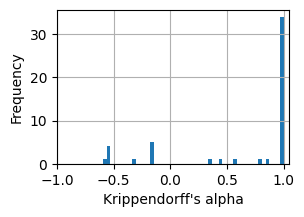

In [16]:
from matplotlib import pyplot as plt
plt.figure(figsize=(3, 2))
item_icas.alpha.hist(bins=50)
# plt.yscale('log')
plt.xlabel("Krippendorff's alpha")
plt.ylabel("Frequency")
plt.xlim(-1, 1.05)
plt.show()

In [17]:
# what's the average sentence-level agreement across sentences?
item_icas.alpha.mean()

0.6638852793174124

In [18]:
# and in sentences with min. one annotation?
item_icas.query('no_annos == False').alpha.mean()

0.11548757715108493

In [19]:
# share with "unacceptable" agreement?
(item_icas.alpha < 0.65).mean()

0.28

#### clear cut

In [20]:
tmp = item_icas[item_icas.alpha == 1.0]
tmp = tmp.sort_values(['alpha', 'item_id'])
print(tmp.item_id.nunique())
print(tmp.item_id.nunique()/len(per_item_ica))

34
0.68


In [21]:
tab = item_icas[['item_id', 'text_id', 'n_annos']].drop_duplicates().n_annos.value_counts().sort_index().reset_index()
tab['prop'] = tab['count'] / tab['count'].sum()
tab.columns = ['n_annotations', 'count', 'proportion']
tab

,n_annotations,count,proportion
0,0,31,0.62
1,1,10,0.20
2,2,7,0.14
3,3,2,0.04


In [22]:
ex = item_icas[item_icas.n_annos==3].iloc[1]
print(ex.text)
print(*annotations[annotations.item_id == ex.item_id].spans.tolist(), sep='\n')

A national programme will be launched, in cooperation with State Governments, to provide bicycles to girls from Below Poverty Line Families who attend school .
[]
['provide bicycles to girls from Below Poverty Line Families who attend school']
['to provide bicycles to girls from Below Poverty Line Families who attend school']
['A national programme will be launched, in cooperation with State Governments, to provide bicycles to girls from Below Poverty Line Families who attend school']


#### good(ish)

In [23]:
tmp = item_icas[np.logical_and(item_icas.alpha >= 0.65, item_icas.alpha < 1.0)]
tmp = tmp.sort_values(['alpha', 'item_id'])
print(tmp.item_id.nunique())
print(tmp.item_id.nunique()/len(per_item_ica))

2
0.04


In [24]:
items = tmp.item_id.unique()
examples = tmp[tmp.item_id.isin(items)].merge(annotations[['item_id', 'annotator', 'spans']], on='item_id', how='left')
for item, ex in examples.groupby('item_id'):
    print(f"Item: {item}, k-alpha: {ex.alpha.iloc[0]:.4f}")
    print("Text:", repr(ex['text'].iloc[0]))
    print("Spans:")
    for m, span in zip(ex['annotator'], ex['spans']):
        print(f" - {span} ({m})")
    print("\n---\n")

Item: 10, k-alpha: 0.7883
Text: 'a . We will ensure the passage of the Women’s Reservation Bill .'
Spans:
 - ['ensure the passage of the Women’s Reservation Bill'] (DeepSeek-V3-0324)
 - ['ensure the passage of the Women’s Reservation Bill'] (Llama-4-Maverick-17B-128E-Instruct)
 - ['We will ensure the passage of the Women’s Reservation Bill'] (Qwen3-235B-A22B-Instruct-2507)
 - ['We will ensure the passage of the Women’s Reservation Bill'] (gpt-oss-120b)

---

Item: 38, k-alpha: 0.8579
Text: 'We will recognise the 11 left out Indian Gorkha sub - tribes as Schedule Tribes .'
Spans:
 - ['recognise the 11 left out Indian Gorkha sub - tribes as Schedule Tribes'] (DeepSeek-V3-0324)
 - ['recognise the 11 left out Indian Gorkha sub - tribes as Schedule Tribes'] (Llama-4-Maverick-17B-128E-Instruct)
 - ['recognise the 11 left out Indian Gorkha sub - tribes as Schedule Tribes'] (Qwen3-235B-A22B-Instruct-2507)
 - ['We will recognise the 11 left out Indian Gorkha sub - tribes as Schedule Tribes .'] 

#### poor

In [25]:
tmp = item_icas[np.logical_and(item_icas.alpha >= 0.0, item_icas.alpha < 0.65)]
tmp = tmp.sort_values(['alpha', 'item_id'])
print(tmp.item_id.nunique())
print(tmp.item_id.nunique()/len(per_item_ica))

3
0.06


In [26]:
items = tmp.item_id.unique()
examples = tmp[tmp.item_id.isin(items)].merge(annotations[['item_id', 'annotator', 'spans']], on='item_id', how='left')
for item, ex in examples.groupby('item_id'):
    print(f"Item: {item}, k-alpha: {ex.alpha.iloc[0]:.4f}")
    print("Text:", repr(ex['text'].iloc[0]))
    print("Spans:")
    for m, span in zip(ex['annotator'], ex['spans']):
        print(f" - {span} ({m})")
    print("\n---\n")

Item: 13, k-alpha: 0.3613
Text: 'We will restrict foreign equity holding in private television broadcasting to 20% (and prevent cross holding to avoid emergence of monopolies in the media) .'
Spans:
 - ['restrict foreign equity holding in private television broadcasting to 20% (and prevent cross holding to avoid emergence of monopolies in the media)'] (DeepSeek-V3-0324)
 - ['restrict foreign equity holding in private television broadcasting to 20%'] (Llama-4-Maverick-17B-128E-Instruct)
 - ['We will restrict foreign equity holding in private television broadcasting to 20% (and prevent cross holding to avoid emergence of monopolies in the media)'] (Qwen3-235B-A22B-Instruct-2507)
 - ['We will restrict foreign equity holding in private television broadcasting to 20% (and prevent cross holding to avoid emergence of monopolies in the media)'] (gpt-oss-120b)

---

Item: 27, k-alpha: 0.4409
Text: 'Every consumer of electricity in India, including farmers, would be connected through digital, ta

#### bad

In [27]:
tmp = item_icas[item_icas.alpha < 0.0]
tmp = tmp.sort_values(['alpha', 'item_id'])
print(tmp.item_id.nunique())
print(tmp.item_id.nunique()/len(per_item_ica))

11
0.22


In [28]:
items = tmp.item_id.unique()
examples = tmp[tmp.item_id.isin(items)]
# draw random sample of 3 examples
examples = examples.sample(3, random_state=42)
examples = examples.merge(annotations[['item_id', 'annotator', 'spans']], on='item_id', how='left')
for item, ex in examples.groupby('item_id'):
    print(f"Item: {item}, k-alpha: {ex.alpha.iloc[0]:.4f}")
    print("Text:", repr(ex['text'].iloc[0]))
    print("Spans:")
    for m, span in zip(ex['annotator'], ex['spans']):
        print(f" - {span} ({m})")
    print("\n---\n")

Item: 7, k-alpha: -0.3087
Text: 'We will also introduce a multi - purpose identity card for all citizens .'
Spans:
 - [] (DeepSeek-V3-0324)
 - ['introduce a multi - purpose identity card for all citizens'] (Llama-4-Maverick-17B-128E-Instruct)
 - ['introduce a multi - purpose identity card for all citizens'] (Qwen3-235B-A22B-Instruct-2507)
 - ['We will also introduce a multi - purpose identity card for all citizens .'] (gpt-oss-120b)

---

Item: 40, k-alpha: -0.1511
Text: 'Reservations for the poor among ‘Forward Classes’ will be introduced after receiving recommendations of the Commission set up for this purpose .'
Spans:
 - ['Reservations for the poor among ‘Forward Classes’ will be introduced after receiving recommendations of the Commission set up for this purpose'] (DeepSeek-V3-0324)
 - [] (Llama-4-Maverick-17B-128E-Instruct)
 - ['Reservations for the poor among ‘Forward Classes’ will be introduced after receiving recommendations of the Commission set up for this purpose'] (Qwen3-2